# MLP with Keras

In [ ]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)
print(keras.__version__)

2.4.1
2.4.0


In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

In [ ]:
X_train_full.shape

(60000, 28, 28)

In [ ]:
X_train_full.dtype

dtype('uint8')

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255.0, X_train_full[5000:] / 255.0
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
"Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]
class_names[y_train[0]]

'Coat'

In [ ]:
%matplotlib inline

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

In [ ]:
img = X_train[0]

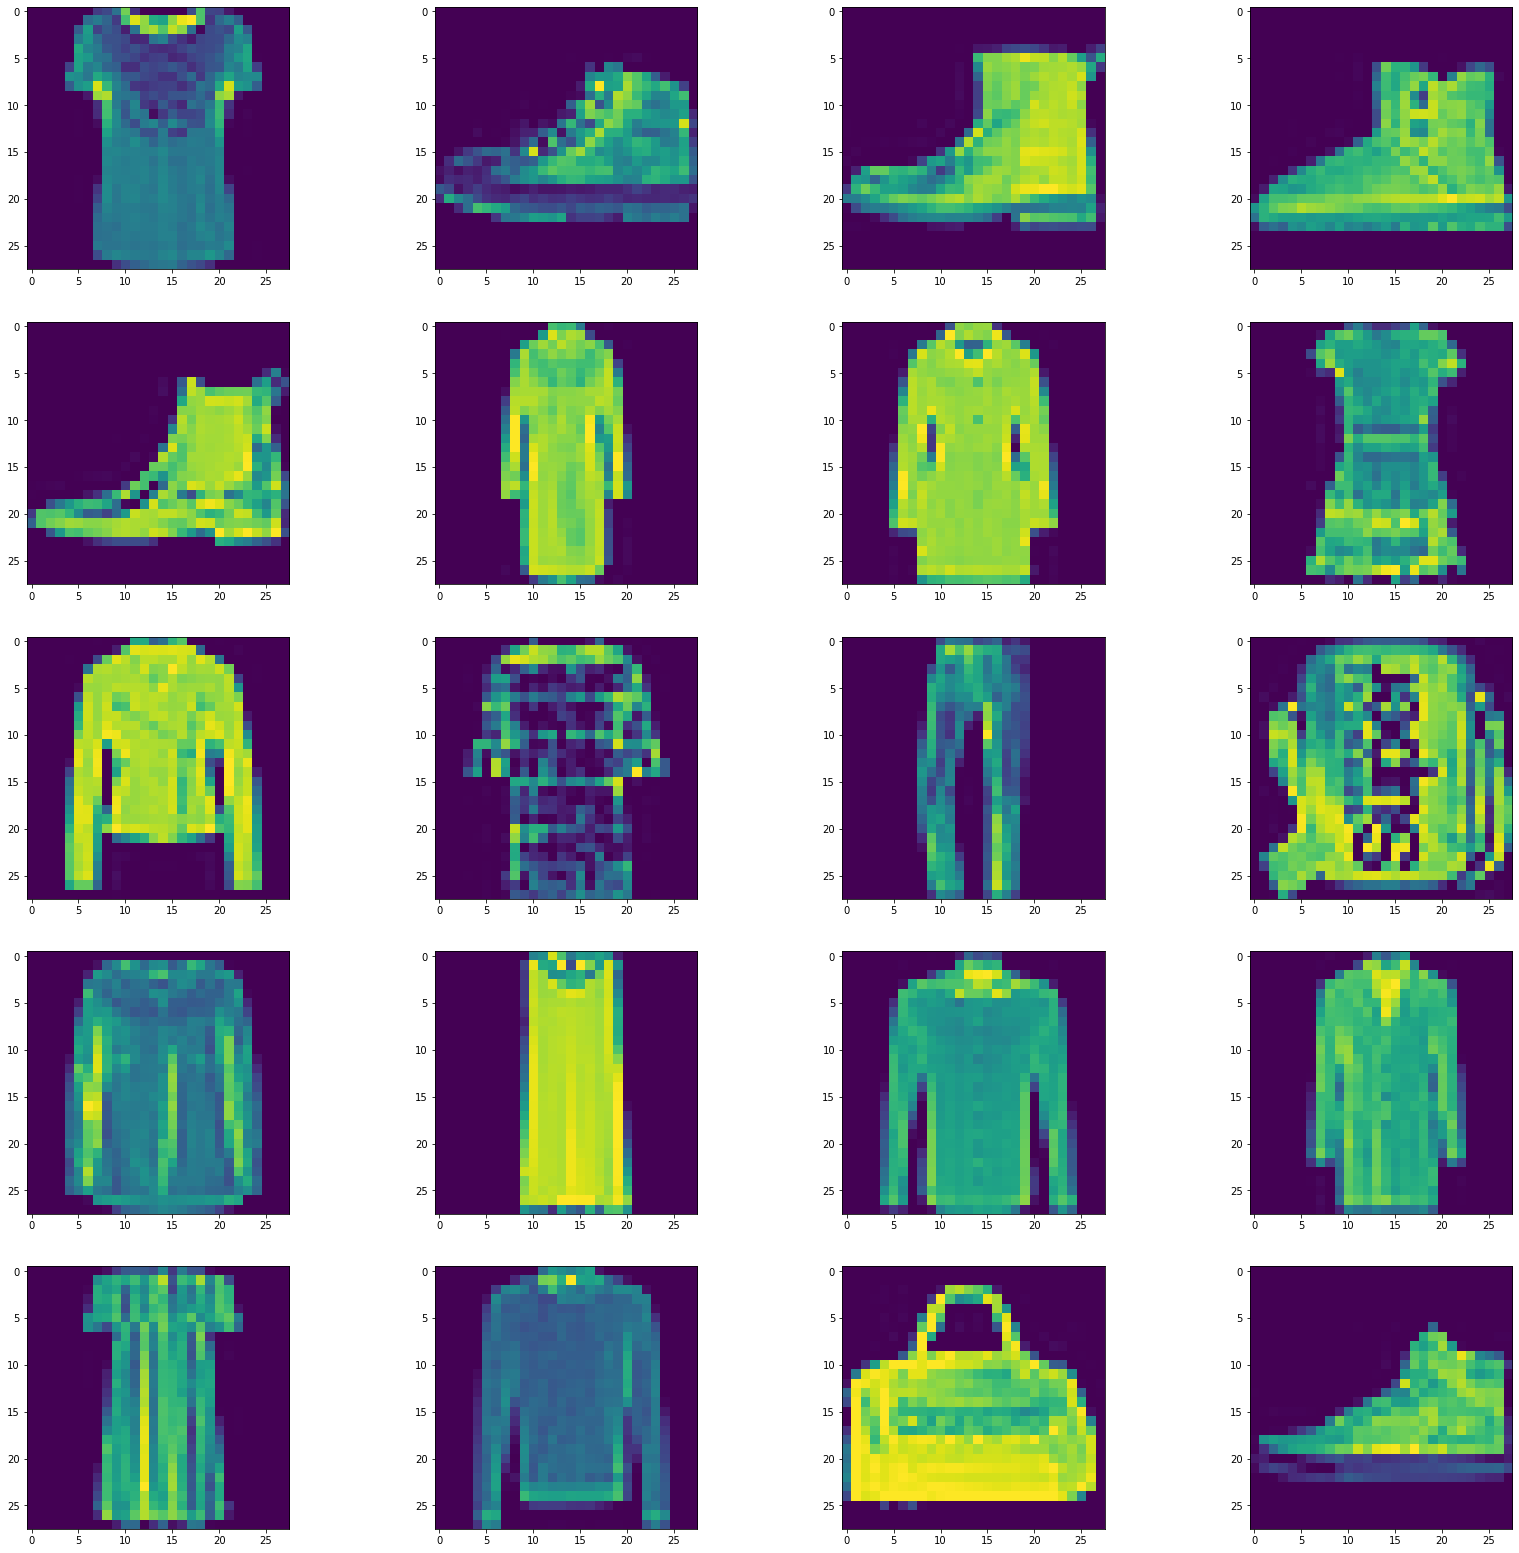

In [ ]:
# first 20 images
img = 0
columns = 4
rows = 5
fig = plt.figure(figsize=(28,28))
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


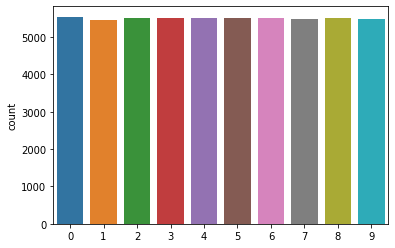

In [ ]:
sns.countplot(y_train)

# Creating the model using Sequentail API

In [ ]:
cnn = keras.models.Sequential()
cnn.add(keras.layers.InputLayer(input_shape=(28, 28, 1)))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='selu', input_shape=[28, 28,2], kernel_initializer='lecun_normal'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.AlphaDropout(0.1)) # when we use selu activation function we have to use Alphadroput for better effect
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='selu', kernel_initializer='lecun_normal'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.AlphaDropout(0.1))
cnn.add(tf.keras.layers.Flatten(input_shape=[28, 28,2]))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.Dense(units=200, activation='selu', kernel_initializer='lecun_normal'))
cnn.add(tf.keras.layers.BatchNormalization())
cnn.add(tf.keras.layers.AlphaDropout(0.1))
cnn.add(keras.layers.Dense(10, activation="softmax"))

In [ ]:
cnn.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_20 (Batc (None, 28, 28, 1)         4         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
batch_normalization_21 (Batc (None, 26, 26, 32)        128       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 13, 13, 32)        0         
_________________________________________________________________
alpha_dropout_12 (AlphaDropo (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 11, 11, 32)        9248      
_________________________________________________________________
batch_normalization_22 (Batc (None, 11, 11, 32)       

In [ ]:
optimizer = keras.optimizers.Nadam()
cnn.compile(loss="sparse_categorical_crossentropy",
optimizer=optimizer,
metrics=["accuracy"])

In [ ]:
X_train = tf.reshape(X_train, (55000,28,28,1)).numpy()
X_valid = tf.reshape(X_valid, (5000, 28, 28,1)).numpy()
X_train.shape


(55000, 28, 28, 1)

In [ ]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    height_shift_range = 0.1,
    width_shift_range = 0.1

)
datagen.fit(X_train)
datagen.fit(X_valid)
X_train.shape

(55000, 28, 28, 1)

In [ ]:
K = keras.backend
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (self.iteration - iter1)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [ ]:
import math
n_epochs = 25
batch_size = 128
onecycle = OneCycleScheduler(math.ceil(len(X_train) / batch_size) * n_epochs, max_rate=0.01, start_rate=0.0005)

In [ ]:

history = cnn.fit(X_train, y_train, 
validation_data=(X_valid, y_valid), 
batch_size = batch_size,
epochs=n_epochs,
callbacks=[onecycle]


)

Epoch 1/25
430/430 [==============================] - 67s 150ms/step - loss: 0.6612 - accuracy: 0.7628 - val_loss: 0.4384 - val_accuracy: 0.8650
Epoch 2/25
430/430 [==============================] - 64s 149ms/step - loss: 0.4141 - accuracy: 0.8483 - val_loss: 0.3457 - val_accuracy: 0.8918
Epoch 3/25
430/430 [==============================] - 64s 148ms/step - loss: 0.3370 - accuracy: 0.8758 - val_loss: 0.3809 - val_accuracy: 0.8878
Epoch 4/25
430/430 [==============================] - 64s 148ms/step - loss: 0.2964 - accuracy: 0.8888 - val_loss: 0.3263 - val_accuracy: 0.8984
Epoch 5/25
430/430 [==============================] - 64s 149ms/step - loss: 0.2785 - accuracy: 0.8973 - val_loss: 0.3283 - val_accuracy: 0.9052
Epoch 6/25
430/430 [==============================] - 65s 151ms/step - loss: 0.2626 - accuracy: 0.9027 - val_loss: 0.3348 - val_accuracy: 0.8984
Epoch 7/25
430/430 [==============================] - 64s 148ms/step - loss: 0.2506 - accuracy: 0.9060 - val_loss: 0.3640 - val_ac

In [ ]:
X_train_full = tf.reshape(X_train_full, (60000,28,28,1)).numpy()
X_test = tf.reshape(X_test, (10000,28,28,1)).numpy()

In [ ]:

history2 = cnn.fit(X_train_full, y_train_full, epochs=15,
validation_data=(X_test, y_test),
validation_batch_size=200

)

Epoch 1/15
1875/1875 [==============================] - 45s 24ms/step - loss: 20.9198 - accuracy: 0.9686 - val_loss: 138.1135 - val_accuracy: 0.8918
Epoch 2/15
1875/1875 [==============================] - 51s 27ms/step - loss: 14.2145 - accuracy: 0.9729 - val_loss: 125.2505 - val_accuracy: 0.8943
Epoch 3/15
1875/1875 [==============================] - 45s 24ms/step - loss: 10.3649 - accuracy: 0.9761 - val_loss: 114.0333 - val_accuracy: 0.8942
Epoch 4/15
1875/1875 [==============================] - 45s 24ms/step - loss: 7.8975 - accuracy: 0.9788 - val_loss: 105.9235 - val_accuracy: 0.8943
Epoch 5/15
1875/1875 [==============================] - 45s 24ms/step - loss: 5.9774 - accuracy: 0.9804 - val_loss: 99.0278 - val_accuracy: 0.8913
Epoch 6/15
1875/1875 [==============================] - 45s 24ms/step - loss: 4.7806 - accuracy: 0.9812 - val_loss: 94.4033 - val_accuracy: 0.8933
Epoch 7/15
1875/1875 [==============================] - 45s 24ms/step - loss: 3.6822 - accuracy: 0.9837 - val_l

KeyboardInterrupt: ignored

In [ ]:
X_train_full = tf.reshape(X_train, (55000,28,28,1)).numpy() 

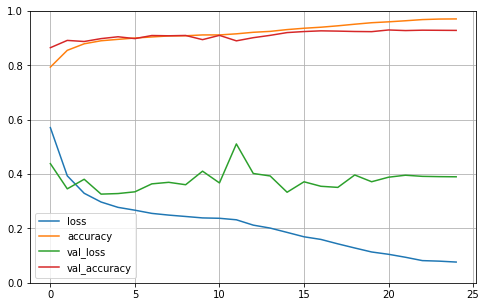

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [ ]:
y_pred = model.predict_classes(X_new)
y_pred

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([9, 2, 1])